In [11]:
import os
from pydantic import BaseModel, Field
from typing import Literal, List
from concurrent.futures import ProcessPoolExecutor, ThreadPoolExecutor
from functools import partial
from rich import print as rprint
from IPython.display import Markdown, display

try:
    _SETUP
    print("Running on folder: ", os.getcwd())
except NameError:
    _SETUP = True
    os.chdir("..")
    print("Running on folder: ", os.getcwd())

from llm.structured import create
import gymnasium
from llm.structured import create, create_iterable, create_sequence
from rich.panel import Panel
from rich.text import Text

Running on folder:  /Users/andre/test/ODSCB


In [2]:
import matplotlib.pyplot as plt
import base64
import io
from PIL import Image
import numpy as np


def display_image(rgb_array):
    plt.figure(figsize=(8, 8))
    plt.imshow(rgb_array)
    plt.axis("off")
    plt.show()


def rgb_array_to_base64_image(rgb_array):
    # Convert numpy array to PIL Image
    img = Image.fromarray(np.uint8(rgb_array))

    # Save image to bytes buffer
    buffer = io.BytesIO()
    img.save(buffer, format="PNG")

    # Encode to base64 and add markdown image prefix
    return "data:image/png;base64," + base64.b64encode(buffer.getvalue()).decode(
        "utf-8"
    )


def base64_to_image_url_message(base_64_image):
    return {
        "role": "user",
        "content": [
            {
                "type": "image_url",
                "image_url": {"url": base_64_image},
                "detail": "high",
            }
        ],
    }

In [3]:
env = gymnasium.make("Blackjack-v1", render_mode="rgb_array")

In [4]:
class State(BaseModel):
    """
    The state of the game of blackjack.

    Player sum: The sum of the player's cards.
    Dealer sum: The sum of the dealer's cards.
    Usable ace: Whether the player has a usable ace. An ace can either count as 11 or 1.
    """

    player_sum: int
    dealer_sum: int
    usable_ace: bool
    reward: float = 0

In [5]:
class Action(BaseModel):
    """
    The action of the game of blackjack.

    Thoughts: The player's thoughts about the current state of the game.
    Hit: Whether the player hits.
    """

    thoughts: str = Field(
        description="The player's thoughts about the current state of the game."
    )
    hit: bool = Field(
        description="True: The player hits and gets another card. False: The player will stick and not get another card."
    )

In [6]:
BLACKJACK_PROMPT = """
You are playing blackjack. You are given the current state of the game and your thoughts about the current state.

The game starts with the dealer having one face up and one face down card, while the player has two face up cards. All cards are drawn from an infinite deck (i.e. with replacement).

The card values are:

Face cards (Jack, Queen, King) have a point value of 10.

Aces can either count as 11 (called a ‘usable ace’) or 1.

Numerical cards (2-9) have a value equal to their number.

The player has the sum of cards held. The player can request additional cards (hit) until they decide to stop (stick) or exceed 21 (bust, immediate loss).

After the player sticks, the dealer reveals their facedown card, and draws cards until their sum is 17 or greater. If the dealer goes bust, the player wins.

If neither the player nor the dealer busts, the outcome (win, lose, draw) is decided by whose sum is closer to 21.

You must decide what to do given the current state of the game and your thoughts about the current state.
"""

messages = [
    {"role": "system", "content": BLACKJACK_PROMPT},
]

In [7]:
class Game(BaseModel):
    """
    The game of blackjack.
    """

    state_history: list[State] = Field(
        description="The history of the game's state.", default_factory=list
    )
    action_history: list[Action] = Field(
        description="The history of the game's actions.", default_factory=list
    )
    history: list[State | Action] = Field(
        description="The history of the game's state and actions.", default_factory=list
    )

    reward: float = Field(description="The reward of the game.", default=0.0)

    env: gymnasium.Env = Field(
        description="The environment of the game.",
        default_factory=lambda: gymnasium.make("Blackjack-v1", render_mode="rgb_array"),
    )

    class Config:
        arbitrary_types_allowed = True

    def get_history(self):
        return [
            {
                "role": "system",
                "content": BLACKJACK_PROMPT,
            }
        ] + [
            {
                "role": "user",
                "content": f"{isinstance(x, State) and 'State' or 'Action'}: {x.model_dump_json()}",
            }
            for x in self.history
        ]

    def initialize(self):
        observation, info = self.env.reset()
        player_sum, dealer_sum, usable_ace = observation
        self.state_history.append(
            State(player_sum=player_sum, dealer_sum=dealer_sum, usable_ace=usable_ace)
        )
        self.history.append(self.state_history[-1])

    def step(self, render=False):
        messages = self.get_history()
        new_action = create(messages, Action)
        observation, reward, terminated, truncated, info = self.env.step(new_action.hit)
        self.reward += reward
        player_sum, dealer_sum, usable_ace = observation
        new_state = State(
            player_sum=player_sum,
            dealer_sum=dealer_sum,
            usable_ace=usable_ace,
            reward=reward,
        )
        if render:
            rprint(new_action)
            display_image(self.env.render())

        self.state_history.append(new_state)
        self.history.append(new_action)
        self.history.append(new_state)

        return terminated or truncated

    def play(self, render=False):
        self.initialize()
        while not self.step(render):
            pass
        return self.reward

Action(
    thoughts='The player has a sum of 13, which is below 17, so it is generally advisable to hit to try to get 
closer to 21 without exceeding it.',
    hit=True
)

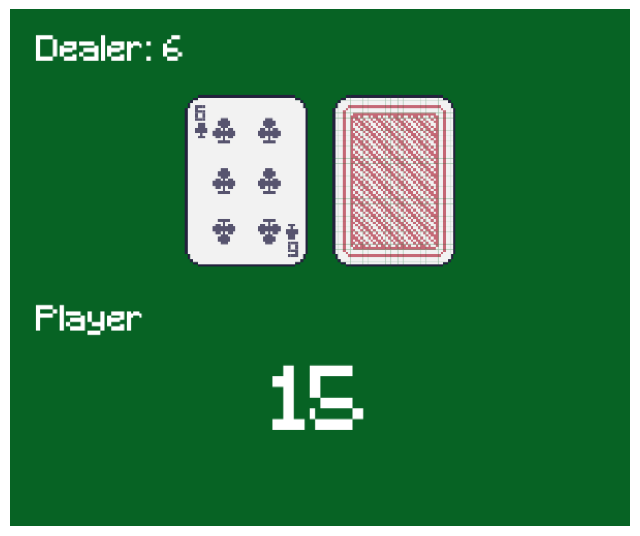

Action(
    thoughts='Now the player has a sum of 15, which is still below 17. To get closer to 21 without exceeding it, 
the player should hit again.',
    hit=True
)

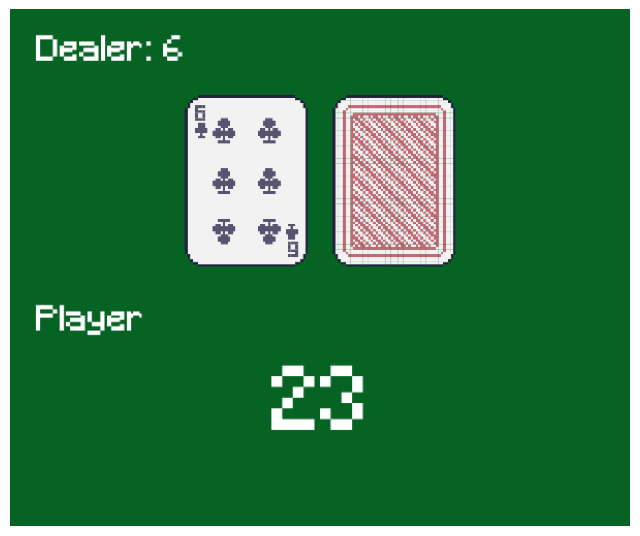

╭─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╮
│                                                                                                                 │
│  Defeat.                                                                                                        │
│                                                                                                                 │
╰─────────────────────────────────────────────────────────────────────────────────────────────────────────────────╯

In [12]:
game = Game()
result = game.play(render=True)


message = (
    Text("Victory!!!", style="bold green")
    if result == 1
    else (
        Text("Tie game.", style="bold yellow")
        if result == 0
        else Text("Defeat.", style="bold red")
    )
)

rprint(Panel(message, border_style="bright_white", padding=(1, 2)))

In [13]:
def play_game(dummy):
    game = Game()
    return game.play()


with ThreadPoolExecutor(max_workers=10) as executor:
    results = list(executor.map(play_game, range(100)))

In [14]:
sum(results) / len(results)

0.0

In [16]:
env = gymnasium.make(
    "FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="rgb_array"
)
env.reset()
env.step(0)

(0, 0.0, False, False, {'prob': 1.0})

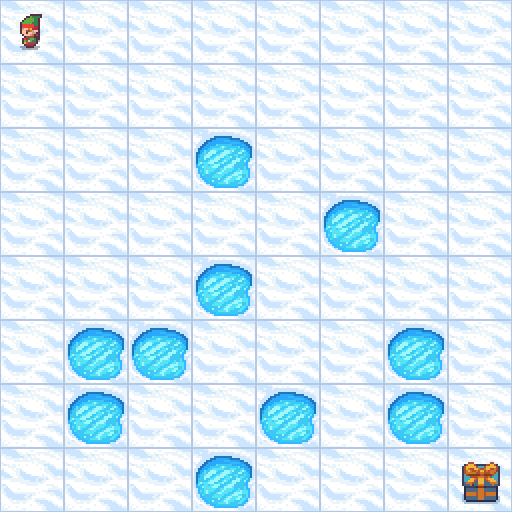

In [18]:
from IPython.display import Markdown


rgb_array = env.render()

Markdown(f"![frozen lake]({rgb_array_to_base64_image(rgb_array)})")

In [19]:
class State(BaseModel):
    """
    State: The current state of the game, stored as a base64 encoded image.
    """

    state: str = Field(
        description="The current state of the game, stored as a base64 encoded image."
    )
    reward: float = 0

    def render(self):
        return Markdown(f"![frozen lake]({self.state})")

In [20]:
class Action(BaseModel):
    """
    Action: The action of the game.
    """

    thoughts: str = Field(
        description="The player's thoughts about the current state of the game and why you're taking this action.."
    )

    action: Literal["left", "right", "up", "down"] = Field(
        description="The action of the game."
    )

    decoded_map: str = Field(
        description="The decoded map of the game. Give me an ASCII representation of the map you believe you will land on after taking this action."
    )


class ActionSequence(BaseModel):
    sequence: List[Action]


def action_to_int(action):
    return {"left": 0, "down": 1, "right": 2, "up": 3}[action]


def int_to_action(i):
    return {0: "left", 1: "down", 2: "right", 3: "up"}[i]

In [21]:
default_map = """
“P” for the player tile
“G” for Goal tile
“.” for a normal tile
“H” for a tile with a hole

[
        "P.......",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]
"""

In [22]:
LAKE_PROMPT = """
You are playing the game of frozen lake. You are given the current state of the game as an image.

The game is a grid of size 8x8. The player can move left, right, up, or down. The player can only move in the four cardinal directions.

The player starts at the top left corner of the grid.

Your goal is to create a plan to reach the goal state. Keep track of your previous actions and where you might end up as you progress.

Give me {n_actions} actions that will take you to the goal state.

For each action, you will give me an ASCII representation of the map you believe will land on after taking this action.

"""

if True:
    LAKE_PROMPT += f"""
    As a hint, here is the ascii representation of the initial state of the map:\n\n
    ```
    {default_map}
    ```
    """

In [23]:
class Game(BaseModel):
    """
    The game of frozen lake.
    """

    state_history: list[State] = Field(default_factory=list)
    action_history: list[Action] = Field(default_factory=list)
    history: list[State | Action] = Field(default_factory=list)
    reward: float = 0

    env: gymnasium.Env = Field(
        default_factory=lambda: gymnasium.make(
            "FrozenLake-v1", map_name="8x8", is_slippery=False, render_mode="rgb_array"
        )
    )

    class Config:
        arbitrary_types_allowed = True

    def get_history(self, n_actions: int):
        return (
            [
                {"role": "system", "content": LAKE_PROMPT.format(n_actions=n_actions)},
            ]
            + [
                {
                    "role": "user",
                    "content": f"{isinstance(x, State) and 'State' or 'Action'}: {x.model_dump_json()}",
                }
                for x in self.action_history
            ]
            + [base64_to_image_url_message(self.state_history[-1].state)]
        )

    def initialize(self):
        observation, info = self.env.reset()
        rgb_array = self.env.render()
        self.state_history.append(State(state=rgb_array_to_base64_image(rgb_array)))
        self.history.append(self.state_history[-1])

    def render(self):
        return self.state_history[-1].render()

    def _iterate_action(self, new_action: Action):
        rprint(new_action)
        display(Markdown(f"```\n\n{new_action.decoded_map}\n\n```"))
        observation, reward, terminated, truncated, info = self.env.step(
            action_to_int(new_action.action)
        )
        self.reward += reward
        rgb_array = self.env.render()

        display_image(rgb_array)

        new_state = State(state=rgb_array_to_base64_image(rgb_array))
        self.state_history.append(new_state)
        self.action_history.append(new_action)

        self.history.append(new_action)
        self.history.append(new_state)
        return terminated or truncated

    def step(self):
        messages = self.get_history(n_actions=1)
        new_action = create(messages, Action)

        return self._iterate_action(new_action)

    def play(self):
        self.initialize()
        while not self.step():
            pass
        return self.reward

    def step_many_one_shot(self, n_actions: int):
        messages = self.get_history(n_actions=n_actions)
        actions = create_iterable(messages, Action)

        for new_action in actions:
            terminated = self._iterate_action(new_action)
            if terminated:
                return 1

        return 0

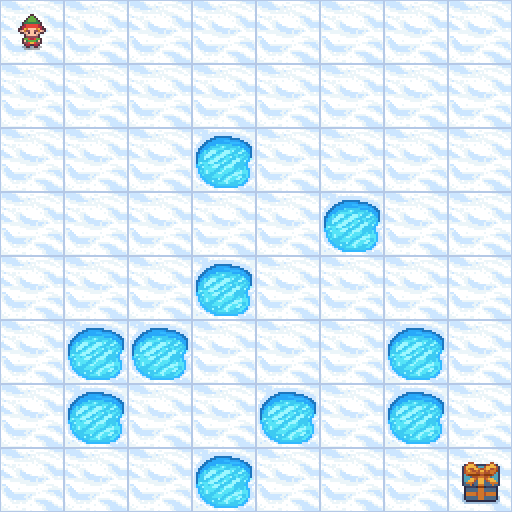

In [29]:
game = Game()
game.initialize()
game.render()

Action(
    thoughts='Starting at the top-left corner (Player at P). First move, go right to approach the goal.',
    action='right',
    decoded_map='[\n        ".P......",\n        "........",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        ".P......",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

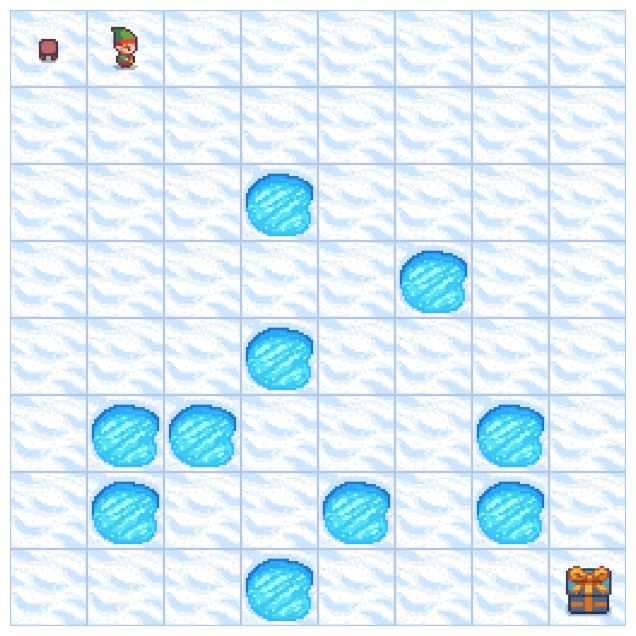

Action(
    thoughts='Player will continue to move right to get closer to the goal.',
    action='right',
    decoded_map='[\n        "..P.....",\n        "........",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        "..P.....",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

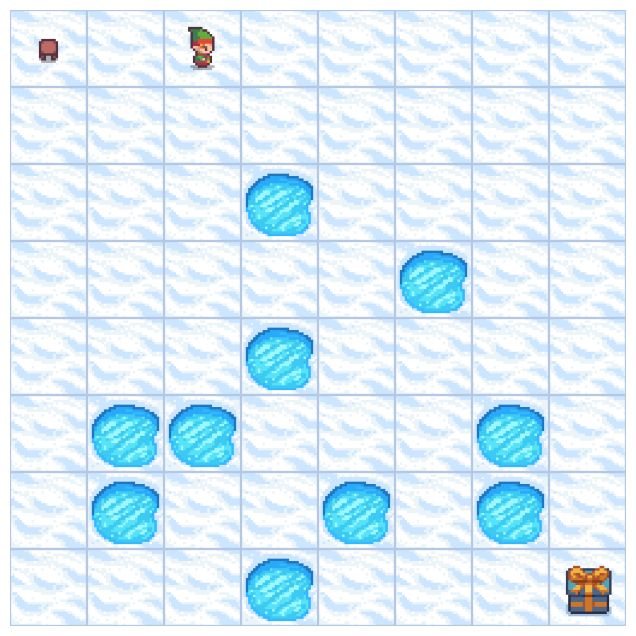

Action(
    thoughts='Keeping the path clear, continue moving to the right.',
    action='right',
    decoded_map='[\n        "...P....",\n        "........",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        "...P....",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

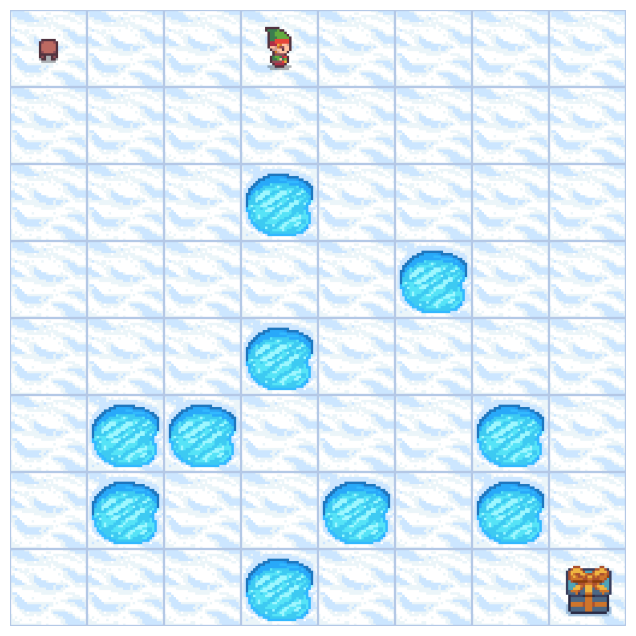

Action(
    thoughts='Now moving down to avoid obstacles and toward the goal.',
    action='down',
    decoded_map='[\n        "........",\n        "...P....",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        "........",
        "...P....",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

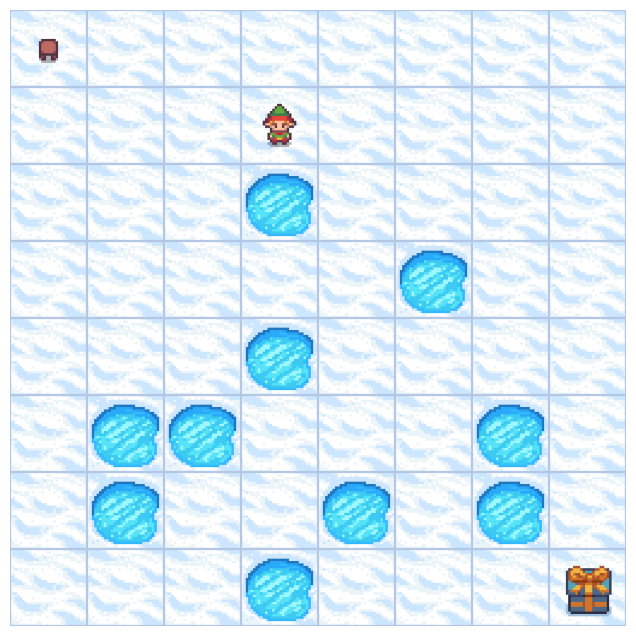

Action(
    thoughts='Continue moving down to safely navigate the map.',
    action='down',
    decoded_map='[\n        "........",\n        "........",\n        "...P....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        "........",
        "........",
        "...P....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

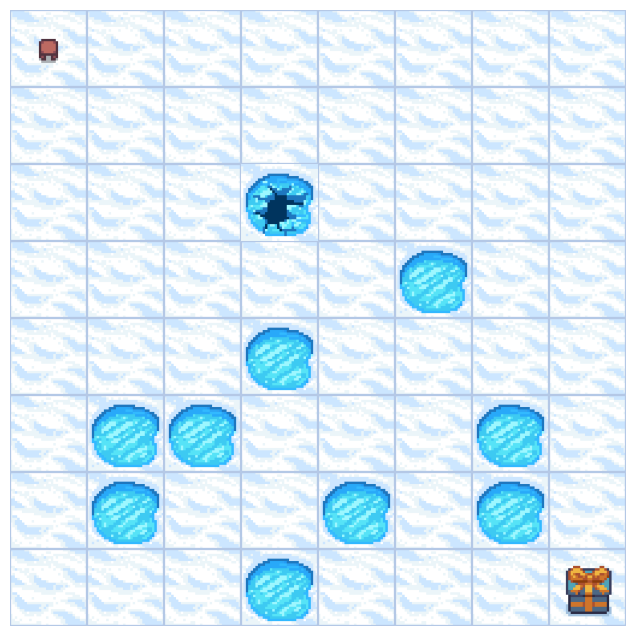

1

In [26]:
game.step_many_one_shot(n_actions=10)

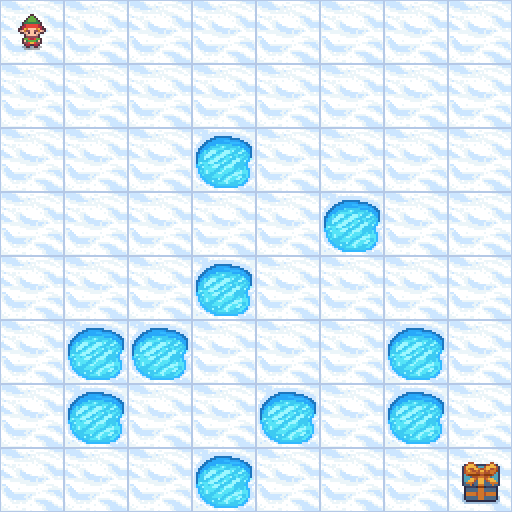

In [30]:
game = Game()
game.initialize()
game.render()

Action(
    thoughts='The player is currently at the top-left corner of the grid. My first move will be to go one step to 
the right to begin navigating toward the goal, while avoiding the holes.',
    action='right',
    decoded_map='[\n        ".P......",\n        "........",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        ".P......",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

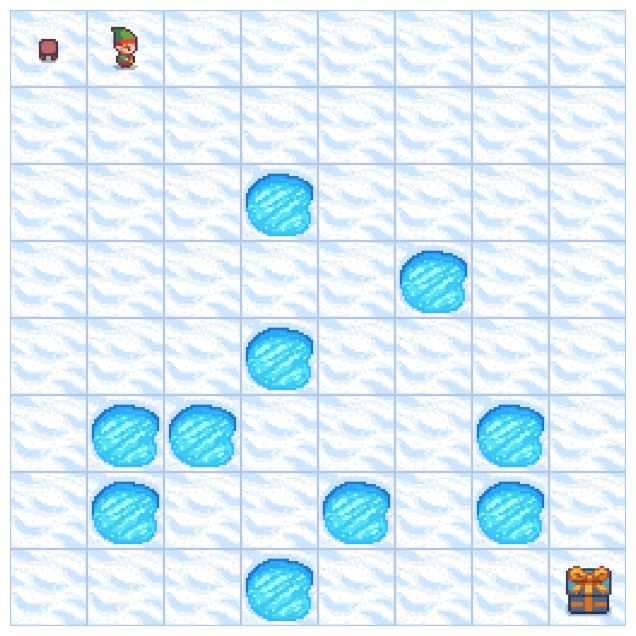

Action(
    thoughts='The player is currently at the top-left corner of the grid. My first move will be to go one step to 
the right to begin navigating toward the goal, while avoiding the holes.',
    action='right',
    decoded_map='[\n        ".P......",\n        "........",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        ".P......",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

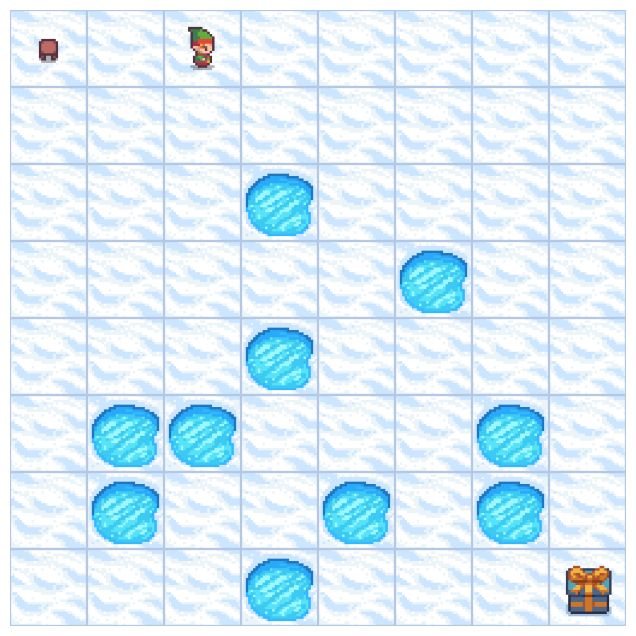

Action(
    thoughts='After the first move to the right, the player has reached the second column in the top row. By 
observing the grid, the path appears safe for another rightward move to advance closer to the goal.',
    action='right',
    decoded_map='[\n        "..P.....",\n        "........",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        "..P.....",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

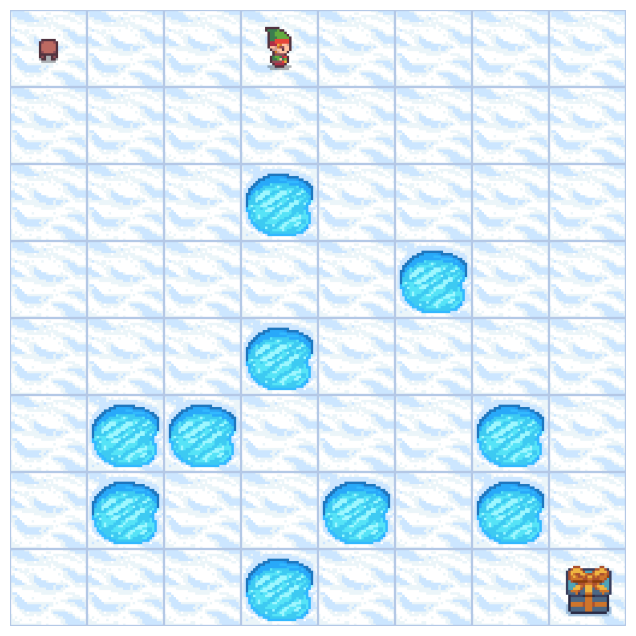

Action(
    thoughts="The player has safely moved two steps to the right and is now on the third column in the top row. 
I'll continue moving right to advance toward the goal while ensuring the path remains clear.",
    action='right',
    decoded_map='[\n        "...P....",\n        "........",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        "...P....",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

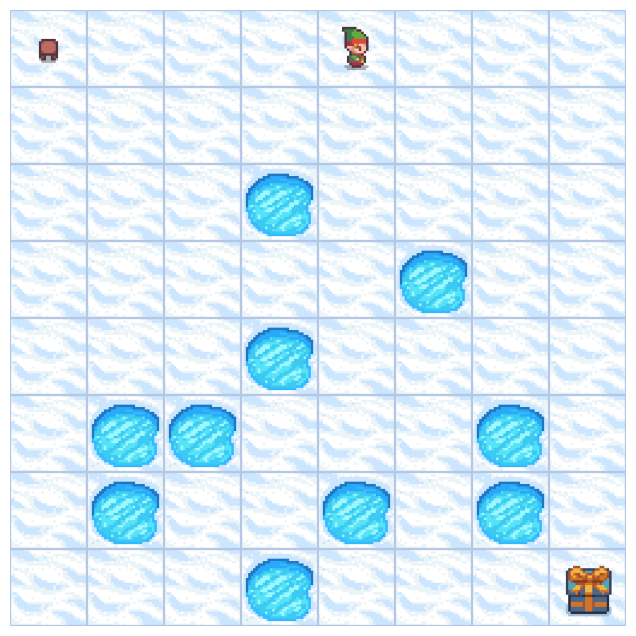

Action(
    thoughts='I can see the updated state of the game. The player is in the third column of the first row. From 
this position, I will move right again to continue toward the goal.',
    action='right',
    decoded_map='[\n        "....P...",\n        "........",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        "....P...",
        "........",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

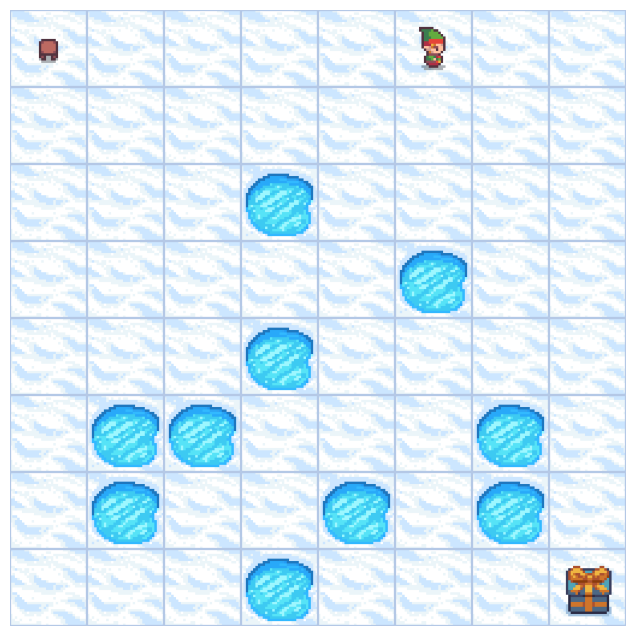

Action(
    thoughts='The player has moved four steps to the right and is now in the fifth column of the first row. From 
this position, I will move downward to avoid the hole in the row below and continue toward the goal.',
    action='down',
    decoded_map='[\n        ".....P..",\n        "....P...",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        ".....P..",
        "....P...",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

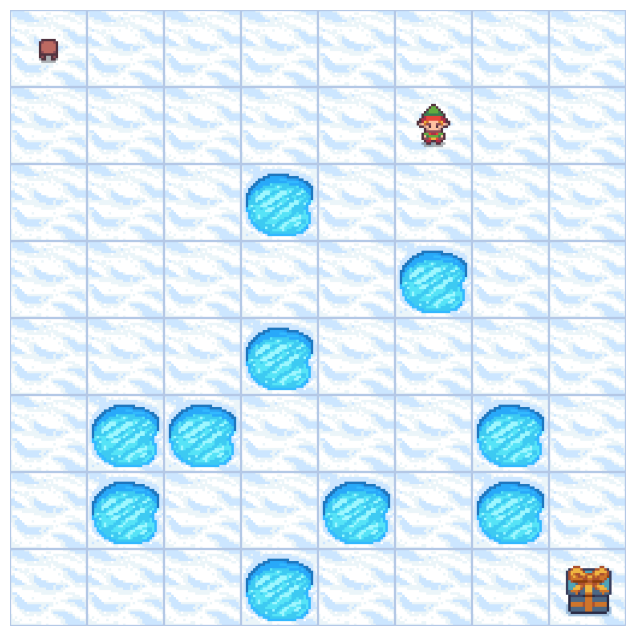

Action(
    thoughts="The player is currently positioned in the fifth column of the first row. From this position, it's 
safe to proceed downward into the second row where there are no immediate holes.",
    action='down',
    decoded_map='[\n        ".....P..",\n        ".....P..",\n        "...H....",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        ".....P..",
        ".....P..",
        "...H....",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

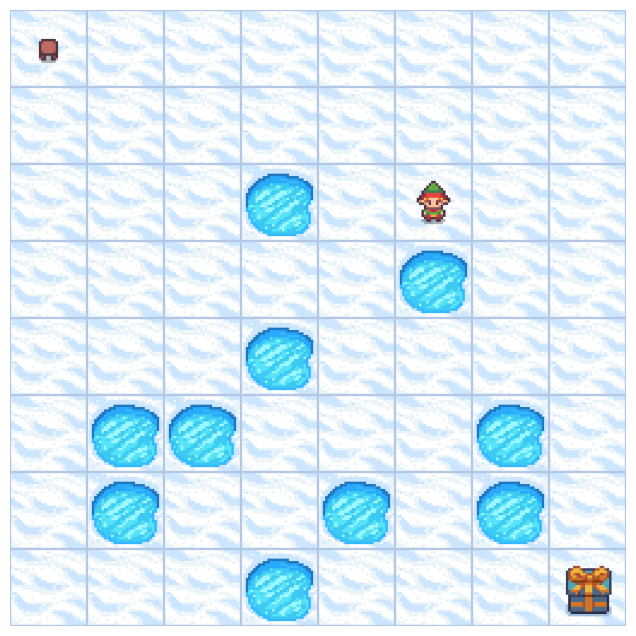

Action(
    thoughts='From the current position, the player needs to avoid the holes and start moving downward to get 
closer to the goal. Moving down is a safe move because there are no holes directly below.',
    action='down',
    decoded_map='[\n        "........",\n        ".....P..",\n        ".....P..",\n        ".....H..",\n        
"...H....",\n        ".HH...H.",\n        ".H..H.H.",\n        "...H...G",\n]'
)

```

[
        "........",
        ".....P..",
        ".....P..",
        ".....H..",
        "...H....",
        ".HH...H.",
        ".H..H.H.",
        "...H...G",
]

```

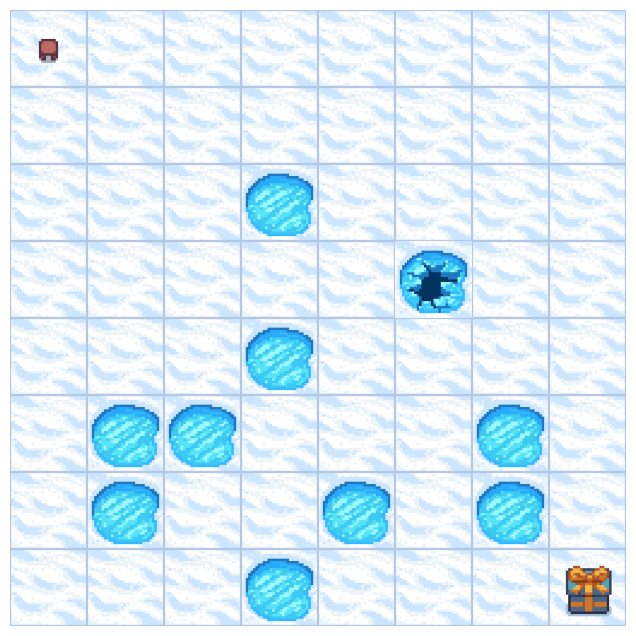

0.0

In [31]:
game.play()